In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
files = glob.glob(f"{data_folder}\\*.parquet")


Load in the data:

In [3]:
df_data = pd.read_parquet(files[0])
df_data.head()

,T,Pev,P,Q
1980-01-01,-4.244118,0.212411,0.000000,1.432909
1980-01-02,-3.066830,0.167835,0.000000,1.367777
1980-01-03,-6.372549,0.235660,0.023756,1.335211
1980-01-04,-10.202124,0.167202,0.000000,1.253795
1980-01-05,-7.726471,0.192151,0.000000,1.179358


Define function to calculate and plot Budyko and the long term water balance. Herefore the average precipitation, discharge and potential evaporation is calculated. 

In [12]:
def budyko(df_data_1, show=True):
    df_data_1.dropna(inplace=True)
    df_data = df_data_1.copy()
    
    fig, ax = plt.subplots()
    #Calculate mean
    p_mean = df_data_1.P.mean()
    q_mean = df_data_1.Q.mean()
    ep_mean = df_data_1.Pev.mean()
    
    df_data_1['Ea_P'] = 1 - df_data_1['Q'] / df_data_1['P']
    
    EA_P = 1 - q_mean / p_mean
    EP_P  = ep_mean / p_mean
    
    EP_P_max = int(EP_P + 5)
    EP_P_array = np.linspace(1e-9, EP_P_max, EP_P_max*10)
    
    #Calculate theoretical Budyko
    budyko = (EP_P_array * np.tanh(1 / EP_P_array) * (1 - np.exp(-EP_P_array))) ** 0.5
    budyko_EP = (EP_P * np.tanh(1 / EP_P) * (1 - np.exp(-EP_P))) ** 0.5
    budyko_EA = budyko_EP * p_mean

    dS_dt = p_mean - q_mean - budyko_EA
    
    #Make figure
    
    
    ax.plot([0,1], [0,1], 'r')
    ax.plot([1, EP_P_max], [1, 1], 'b')
    ax.set_xlabel('$E_p$/P [-]')
    ax.set_ylabel('$E_A$/P [-]')

    ax.set_title(f'Long term water balance, dS/dT = {dS_dt:.2f} ')
    ax.plot(EP_P, EA_P, 'o', label=f'Partioning point data')
    ax.plot(EP_P_array, budyko, '--', alpha=0.6, label=f'Budyko (1948) ')
    ax.legend()
    
    if show != True:
        plt.close()
    

    return df_data, dS_dt



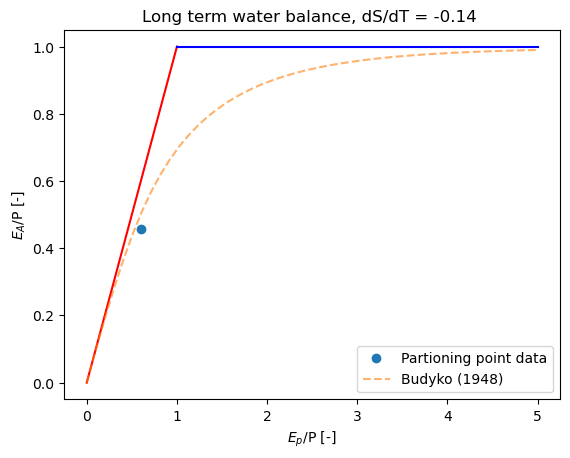

In [13]:
long_term, dS_dt  = budyko(df_data)

### Long term water balance

As can be seen in the figure, the partiononing point is outside of the red line. This means that it is outside of the energy limit. This is due to the fact that the potential evaporation is too low. It was expected that over the long term water balance, more energy would be available for evaporation. 

Now have a look at the flow duration curve. A function is defined to calculate and plot it. For this, the discharge is sorted and ranked and form this the exceeding probability is calculated.

In [14]:
def flow_duration(df, show=True):
    
    df['Q'].dropna(inplace=True) #Drop the nan values
    df_q = df[["Q"]].rename(columns={"Q":"R"})
    
    df_q.sort_values("R",ascending=False,inplace=True)
    df_q = df_q.reset_index().reset_index()
    df_q.set_index("index",inplace=True)
    df_q.rename(columns={"level_0":"m"}, inplace=True)
    
    n = len(df_q)
    df_q['m'] = df_q.apply(lambda x: x.m+1, axis=1)
    df_q['p'] = df_q.apply(lambda x: x.m / (n+1), axis=1)
    
    fig, ax = plt.subplots(2,1,figsize=(6,8))
    fig.tight_layout(h_pad=6)
    
    ax[0].set_ylabel("Runoff Q in [$mm/d$]")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    df[["Q"]].plot(ax = ax[0], color="C0", xlabel='Date')
    
    ax[1].set_ylabel("Runoff Q in [$mm/d$]")
    ax[1].set_xlabel("Excedance probability [-]")
    ax[1].set_title(f"Run off exceedance probability ")
    ax[1].set_yscale("log")
    ax[1].grid()
    ax[1].plot(df_q.p, df_q.R, color="C0")
    
    if show != True:
        plt.close()

    return df_q

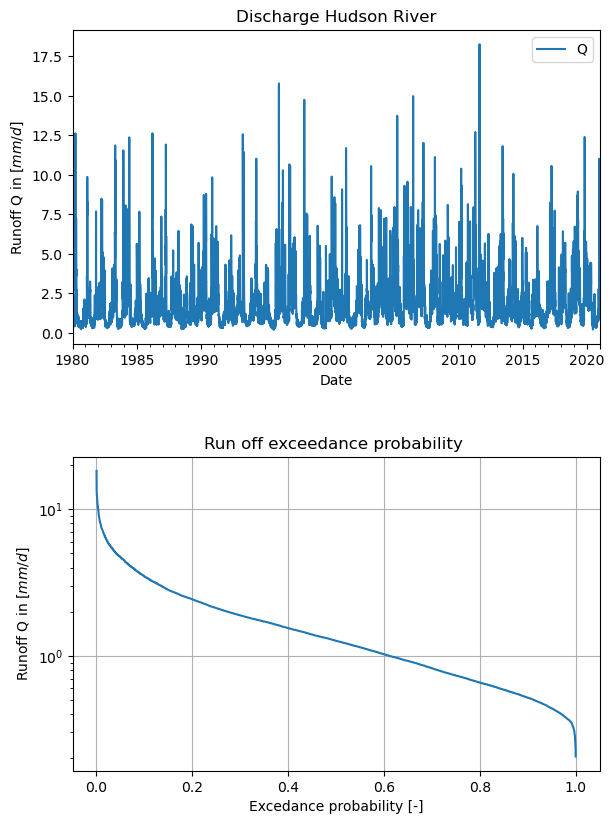

In [15]:
df = flow_duration(df_data)

To check the correlation of discharge between following days, an autocorrelation function is set up. 

In [16]:
def auto_correlation(df, show=True):
    
    df.dropna(inplace=True)
    lag = range(50)
    corr_coeff_1 = []
    
    #calculate correlation coefficient for different time lags
    for i in lag:
        corr_coeff_1.append(df['Q'].autocorr(lag=i))
    
    #plot discharge and results
    fig, ax = plt.subplots(2,1, figsize=(6, 8))
    fig.tight_layout(h_pad=6)
    df['Q'].plot(ax=ax[0],color="C0")

    ax[0].set_ylabel("Runoff Q in [$mm/d$]")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    
    
    ax[1].plot(lag, corr_coeff_1, color="C0")
    
    ax[1].set_ylabel("Correlation Coefficient $[-]$")
    ax[1].set_xlabel("Time lag $[d]$")
    ax[1].set_title(f"Catchment")
    ax[1].grid()
    
    if show != True:
        plt.close()
    
    return corr_coeff_1

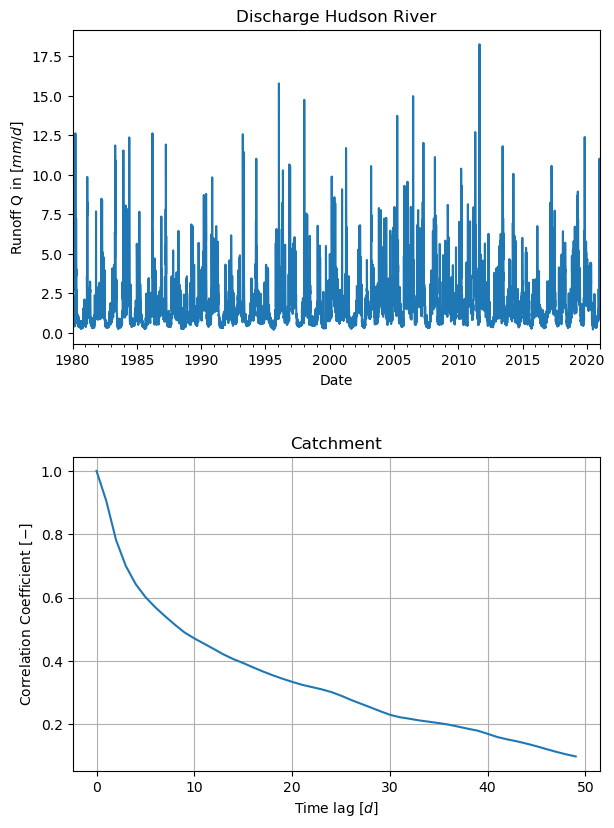

In [17]:
corr = auto_correlation(df_data)